In [82]:
import os
import cv2
import ray
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

from matplotlib import image as img
from scipy.spatial. distance import cosine, euclidean
from scipy.signal import convolve2d
from skimage.feature import graycomatrix
from pyfeats.textural import glcm_features, lte_measures
from sklearn.preprocessing import MinMaxScaler
from random import shuffle

In [2]:
PATH = "./flowers/"
flower_types = [ "bougainvillea", "daisies",  "garden_roses", "gardenias", "hibiscus", "hydrangeas", "lilies", "orchids", "peonies", "tulip" ]

In [3]:
def get_filename(flower_type, idx = 0):
    flowers = list(filter(lambda filename: flower_type in filename, sorted(os.listdir(PATH)) ))
    return flowers[idx]

In [4]:
def read_image(filename, width=256, height=256):
    shape = (width, height)
    return cv2.resize(
        img.imread(PATH + filename),
        shape
    )

In [5]:
def get_image(type_idx=0, idx=0):
    return read_image(
        get_filename(flower_types[type_idx], idx)
    )

In [6]:
files = os.listdir("flowers/")

# Gray-level Co-ocurrence Matrix

In [7]:
def glcm(img, n_values, quantization=1):
    M = np.zeros(shape=(n_values, n_values))
    
    w = int(img.shape[1]/quantization)
    h = int(img.shape[0]/quantization)
    
    img = cv2.resize(img, (w,h))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[0]-1):
            M[ img[i,j], img[i,j+1] ] += 1
    return M/M.sum()

In [24]:
np.all(
    glcm(
        get_image().mean(axis=2).astype(np.uint8), 
        256
    ) == \
    graycomatrix(
        get_image().mean(axis=2).astype(np.uint8), 
        distances=[1], 
        angles=[0], 
        normed=True
    ).reshape(256, 256)
)

True

In [7]:
ray.init()

2023-04-08 17:26:33,767	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.9.7
Ray version:,2.2.0


In [8]:
glcm_features(read_image(files[0]), ignore_zeros=True)[0].reshape(1,-1)

array([[ 5.79765612e-05,  5.96378826e+03,  8.95027308e-03,
         3.01840121e+03,  3.98257685e-02,  1.89784606e+02,
         6.10981659e+03,  8.16231771e+00,  1.45601404e+01,
         4.21201382e-05,  6.75351673e+00, -9.80800227e-02,
         8.35386831e-01,  6.21362683e+00]])

In [9]:
@ray.remote
def get_image_glcm(i, file):
    if (i%50==0): print(i)
    x = glcm_features(
        read_image(file)
    )[0]
    return x.reshape(1,-1)

def get_glcm_features(files):
    X = np.empty(shape=(0, 14))
    
    res = []
    for i, file in enumerate(files):
        res.append( get_image_glcm.remote(i, file, ) ) 
    xys = ray.get(res)
    
    print("Concluded processing the data.\nAppending...")
    
    for x_values in xys:
        X = np.concatenate((X, x_values), axis=0)

    return X

In [10]:
feats = get_glcm_features(files)

(get_image_glcm pid=9664) 0
(get_image_glcm pid=9664) 50
(get_image_glcm pid=14008) 100
(get_image_glcm pid=62196) 150
(get_image_glcm pid=21416) 200
(get_image_glcm pid=62196) 250
(get_image_glcm pid=62196) 300
(get_image_glcm pid=62196) 350
(get_image_glcm pid=21416) 400
(get_image_glcm pid=14008) 450
(get_image_glcm pid=21416) 500
(get_image_glcm pid=14008) 550
(get_image_glcm pid=9664) 600
(get_image_glcm pid=9664) 650
(get_image_glcm pid=62196) 700
Concluded processing the data.
Appending...


In [11]:
ray.shutdown()

In [12]:
feats

array([[ 5.79765612e-05,  5.96378826e+03,  8.95027308e-03, ...,
        -9.80800227e-02,  8.35386831e-01,  6.21362683e+00],
       [ 4.56017945e-05,  7.96391750e+03,  2.09174937e-01, ...,
        -1.12826030e-01,  8.82136774e-01,  6.14100007e+00],
       [ 4.76847631e-04,  3.65009918e+03,  7.51707982e-02, ...,
        -1.67681213e-01,  8.93466423e-01,  5.09573559e+00],
       ...,
       [ 1.18834362e-04,  3.06813665e+03,  5.34717282e-01, ...,
        -1.62917931e-01,  8.99941949e-01,  5.56098882e+00],
       [ 2.83893518e-04,  1.96461003e+03,  7.94147132e-01, ...,
        -2.41030696e-01,  9.68180994e-01,  5.72922453e+00],
       [ 5.23589493e-05,  5.54244430e+03,  4.33809076e-01, ...,
        -7.09637188e-02,  7.57917822e-01,  4.68019395e+00]])

In [13]:
feats_norm = MinMaxScaler().fit_transform(feats)

In [14]:
feats_norm

array([[4.85330876e-05, 4.25863644e-01, 0.00000000e+00, ...,
        8.87314007e-01, 3.95378704e-01, 5.78261856e-01],
       [2.38574703e-05, 5.75523084e-01, 2.07196529e-01, ...,
        8.46481615e-01, 5.69869897e-01, 5.58980645e-01],
       [8.83773252e-04, 2.52742125e-01, 6.85263379e-02, ...,
        6.94585015e-01, 6.12157091e-01, 2.81480098e-01],
       ...,
       [1.69885177e-04, 2.09196845e-01, 5.44074328e-01, ...,
        7.07774768e-01, 6.36326582e-01, 4.04997188e-01],
       [4.99017567e-04, 1.26625593e-01, 8.12537581e-01, ...,
        4.91476822e-01, 8.91024482e-01, 4.49661004e-01],
       [3.73314184e-05, 3.94336631e-01, 4.39652477e-01, ...,
        9.62400337e-01, 1.06230548e-01, 1.71160620e-01]])

In [37]:
k=0
print(files[k])
results = np.argsort([
    cosine(
        feats[k],
        feats[i]
    ) for i in range(feats.shape[0])
])[:15]
results

bougainvillea_00002.jpg


array([  0, 324,  67, 360, 670,  44,  31,  46,  33,   2,   8,  54,  55,
        64,  15], dtype=int64)

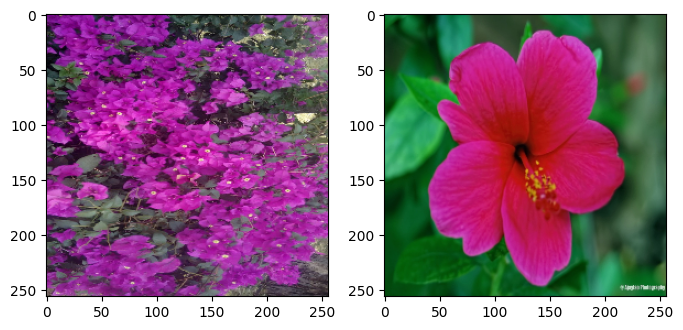

In [39]:
f,ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(read_image(files[k]))
ax[1].imshow(read_image(files[results[1]]))

In [41]:
print(files[k])
results = np.argsort([
    cosine(
        feats_norm[k],
        feats_norm[i]
    ) for i in range(feats.shape[0])
])[:15]
results

bougainvillea_00002.jpg


array([  0, 314,  54, 570, 631, 623, 360, 316, 710,   1,  36,  49,  71,
       637,  67], dtype=int64)

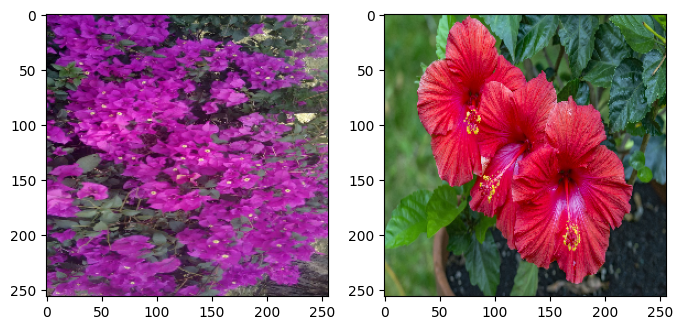

In [42]:
f,ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(read_image(files[k]))
ax[1].imshow(read_image(files[results[1]]))

# Law's Texture Mask

In [43]:
L = np.array([1,4,6,4,1])
E = np.array([-1, -2, 0, 2, 1])
S = np.array([-1,0,2,0,-1])
R = np.array([1, -4, 6, -4, 1])

In [44]:
np.outer(L,L)

array([[ 1,  4,  6,  4,  1],
       [ 4, 16, 24, 16,  4],
       [ 6, 24, 36, 24,  6],
       [ 4, 16, 24, 16,  4],
       [ 1,  4,  6,  4,  1]])

In [67]:
def law_mask(img):
    LE = np.outer(L,E)
    EL = np.outer(E,L)
    
    LS = np.outer(L,S)
    SL = np.outer(S, L)
    
    LR = np.outer(L,R)
    RL = np.outer(R,L)
    
    ES = np.outer(E,S)
    SE = np.outer(S,E)
    
    ER = np.outer(E,R)
    RE = np.outer(R,E)
    
    SR = np.outer(S,R)
    RS = np.outer(R,S)
    
    EE = np.outer(E,E)
    SS = np.outer(S,S)
    RR = np.outer(R,R)
    
    leel = (convolve2d(img, LE) + convolve2d(img, EL))/2
    lssl = (convolve2d(img, LS) + convolve2d(img, SL))/2
    lrrl = (convolve2d(img, LR) + convolve2d(img, RL))/2
    esse = (convolve2d(img, ES) + convolve2d(img, SE))/2
    erre = (convolve2d(img, ER) + convolve2d(img, RE))/2
    srrs = (convolve2d(img, SR) + convolve2d(img, RS))/2
    ee = convolve2d(img, EE)
    ss = convolve2d(img, SS)
    rr = convolve2d(img, RR)
    
    new_shape = leel.shape + (1,)
    return np.concatenate((
        leel.reshape(new_shape),
        lssl.reshape(new_shape),
        lrrl.reshape(new_shape),
        esse.reshape(new_shape),
        erre.reshape(new_shape),
        srrs.reshape(new_shape),
        ee.reshape(new_shape),
        ss.reshape(new_shape),
        rr.reshape(new_shape)
    ), axis=2)

In [71]:
feats = np.array([
    law_mask(read_image(file).mean(axis=2)) for file in files
])

In [77]:
k=10
print(files[k])
results = np.argsort([
    euclidean(
        feats[k].ravel(),
        feats[i].ravel()
    ) for i in range(feats.shape[0])
])[:15]
results

bougainvillea_00013.jpg


array([ 10, 718, 664, 694, 711, 705, 571, 713, 663, 670, 683, 678,   5,
       672, 731], dtype=int64)

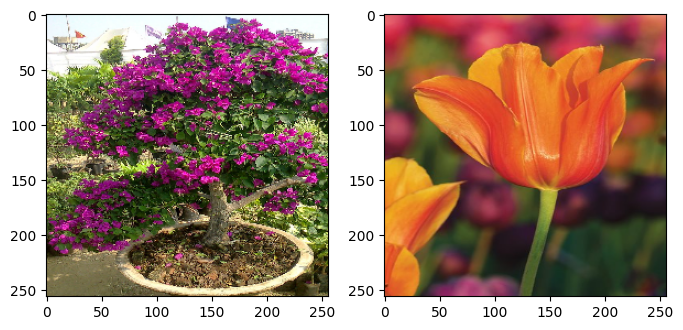

In [78]:
f,ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(read_image(files[k]))
ax[1].imshow(read_image(files[results[1]]))

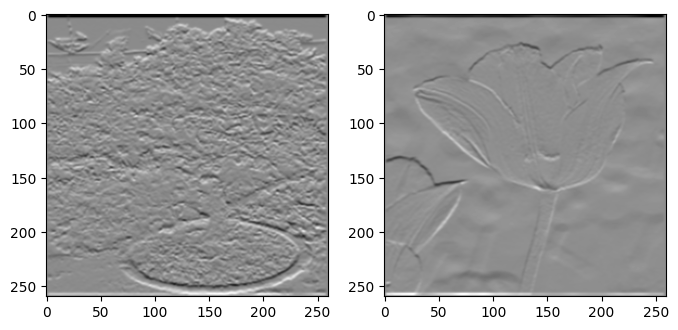

In [81]:
f, ax= plt.subplots(1,2, figsize=(8,8))

ax[0].imshow(
    convolve2d(read_image(files[k]).mean(axis=2), np.outer(E,L)), cmap="gray"
)
ax[1].imshow(
    convolve2d(read_image(files[results[1]]).mean(axis=2), np.outer(E, L)), cmap="gray"
)

# Galbor Filters